## Load the Data

In [8]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [9]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib.patches import Circle,Ellipse
from matplotlib.patches import Rectangle
import os
from PIL import Image
from skimage.transform import resize

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline

In [11]:
from pathlib import Path

In [12]:
#  All dataset path
dataset_path = list(Path('Data').rglob('*.tif'))

In [13]:
print(len(dataset_path))

2688


In [16]:
images = []
def read_images(dataset_path):
    for i in range(len(dataset_path)):
        img = Image.open(dataset_path[i])
        img = img.resize((224, 224))
        img = np.array(img) 
        images.append(img)
    return images

In [17]:
images = read_images(dataset_path)

In [20]:
images_arr = np.asarray(images)
images_arr = images_arr.astype('float32')

In [21]:
images_arr.shape

(2688, 224, 224)

## Data Exploration

In [22]:
# Shapes of training set
print("Dataset (images) shape: {shape}".format(shape=images_arr.shape))

Dataset (images) shape: (2688, 224, 224)


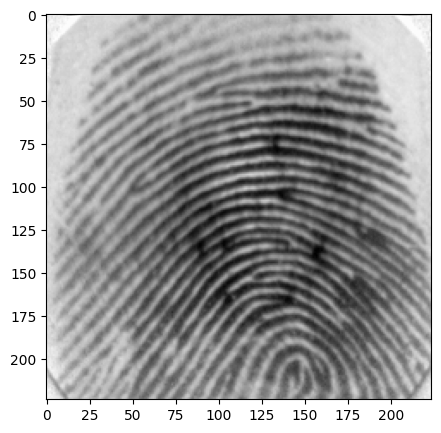

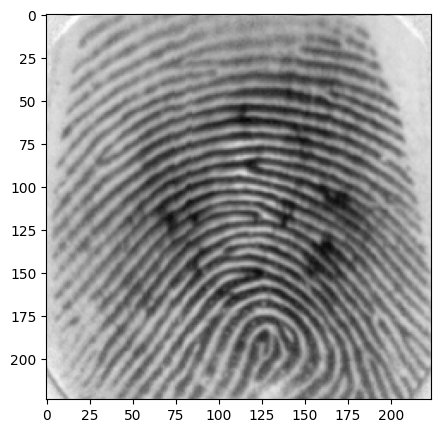

In [23]:
#plt.figure(figsize=[5,5])

# Display the first image in training data
for i in range(2):
    plt.figure(figsize=[5, 5])
    curr_img = np.reshape(images_arr[i], (224,224))
    plt.imshow(curr_img, cmap='gray')
    plt.show()

## Data Preprocessing

In [24]:
images_arr = images_arr.reshape(-1, 224,224, 1)

In [25]:
images_arr.shape

(2688, 224, 224, 1)

In [26]:
images_arr.dtype

dtype('float32')

In [28]:
np.max(images_arr)

255.0

In [29]:
images_arr = images_arr / np.max(images_arr)

In [30]:
np.max(images_arr), np.min(images_arr)

(1.0, 0.0)

In [31]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(images_arr,
                                                             images_arr,
                                                             test_size=0.2,
                                                             random_state=13)

## Network: The Convolutional Autoencoder

In [32]:
batch_size = 128
epochs = 200
inChannel = 1
x, y = 224, 224
input_img = Input(shape = (x, y, inChannel))

In [33]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [34]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [35]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 1)    │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,625 (1.20 MB)

 Trainable params: 314,625 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [ ]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1390s 77s/step - loss: 0.0858 - val_loss: 0.0595
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1531s 91s/step - loss: 0.0572 - val_loss: 0.0414
Epoch 3/200
12/17 ━━━━━━━━━━━━━━━━━━━━ 7:27 89s/step - loss: 0.0380